In [0]:
## setup

# !pip install gym[atari]

In [0]:
## setup

import gym

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
from google.colab import files

# video
import imageio
# embed video to notebook
import base64
# interactive architecture for jupyter notebook
import IPython

In [0]:
## hyperparameter

MAX_STEP = 300
MAX_LENGTH_REPLAY = 10000
VIDEO_NAME_RANDOM = 'random_agent.mp4'

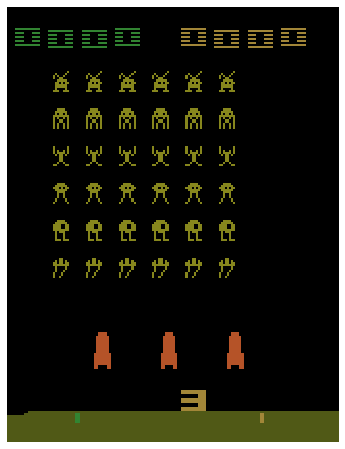

In [4]:
## environment

env = gym.make('SpaceInvaders-v0')
env.reset()

plt.figure(figsize = (8, 8))
plt.imshow(env.render('rgb_array'))
plt.axis('off')
plt.show()

In [5]:
## spec

# Discrete(6) but action index includes 0, 1, 2, 3, 4, 5
print("action space", env.action_space)
print("meaning of action space", env.get_action_meanings())
print("observation space", env.observation_space)

action space Discrete(6)
meaning of action space ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
observation space Box(210, 160, 3)


step:64, action:2, reward:0.0, done:False


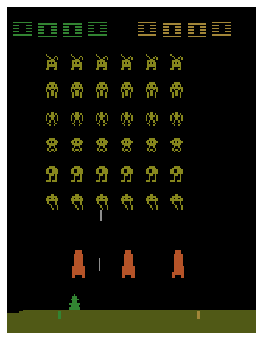

KeyboardInterrupt: ignored

In [6]:
## random policy

# initialize
state = env.reset()
action = 0

for i in range(MAX_STEP):
    clear_output(wait = True)

    next_state, reward, done, info = env.step(action)
    # draw random action
    action = np.random.randint(low = 0, high = 5, size = None, dtype = 'int')

    plt.figure(figsize = (6, 6))
    plt.imshow(next_state)
    plt.axis('off')
    print("step:{}, action:{}, reward:{}, done:{}".format(i, action, reward, done))
    plt.show()
    sleep(.5)

In [7]:
## make mp4 video file

"""
this code outputs mp4 file. 
If you run this in your local PC, video file will be saved in your local directory.
If it's Colab, the video file 
"""

# what's this?
fps = 30
num_episodes = 1

with imageio.get_writer(VIDEO_NAME_RANDOM, fps = fps) as video:
    for _ in range(num_episodes):
        # initialize
        time_step = env.reset()
        done = False
        video.append_data(env.render('rgb_array'))
        
        # start episode
        while not done:
            # draw random action
            action = np.random.randint(low = 0, high = 5, size = None, dtype = 'int')
            # get next state
            next_state, reward, done, info = env.step(action)
            video.append_data(env.render('rgb_array'))

# files.download(VIDEO_NAME_RANDOM)  

MessageError: ignored

In [24]:
## embed video in this notebook

video = open(VIDEO_NAME_RANDOM, 'rb').read()
print("Type of video:", type(video))
print("Length of video file:", len(video))

# encode a string using Base64, returns encoded string, used to generate URL
b64 = base64.b64encode(video)
print("b64encode:", b64)

tag = '''
      <video width = "640" height = "480" controls>
          <source src = "data:video/mp4; base64, {0}" type = "video/mp4">
      Your browser does not support the video tag.
      </video>
      '''.format(b64.decode())

print("tag:", tag)

IPython.display.HTML(tag)

Type of video: <class 'bytes'>
Length of video file: 85299
b64encode: b'AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQABNMttZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1MiByMjg1NCBlOWE1OTAzIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yNS4wIHFjb21wPTAuNjAgcXBtaW49MCBx

In [0]:
## experience replay

class Replay:
    def __init__(self):
        self.buffer = []
        self.length = 0
        self.max_length = MAX_LENGTH_REPLAY

    def write(self, data):
        # if replay is full, delete the oldest (first list) and append the new
        if self.length >= self.max_length:
            self.buffer.pop(0)
            self.length -= 1
        self.buffer.append(data)
        self.length += 1

    def read(self, batch_size):
        # at beginning buffer is almost empty, so batch is smaller than batch_size
        # random.sample is k sample from population without replacement
        return random.sample(population = self.buffer, k = min(batch_size, self.length))

In [0]:
## network

class Network:
    def __init__(self, n_in, n_out):
        self.n_in = n_in
        self.n_out = n_out

    def _build_